<a href="https://colab.research.google.com/github/JLuceroVasquez/data-science-probando-relaciones-con-regresion-lineal/blob/main/precios-de-inmuebles-regresion-lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Precificación inmobiliaria**

**Objetivo**: Estimar los precios de los inmuebles.
 * Identificar los aspectos que tienen más influencia en la precificación de los inmuebles.
 * Entender cuál de todos estos aspectos es el más relevante.
 * Precificar un inmueble nuevo.

Base de datos simplificada e inspirada en [House Prices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)



![](https://i.imgur.com/A8X79yq.jpeg)


# 1. Ajustando una recta

## Conociendo los datos

In [1]:
#Verificando el encode
import chardet

with open('/content/datos-precios-casas.csv','rb') as file:
  diccionario = chardet.detect(file.read())
  encode = diccionario['encoding']

print(encode)

ascii


In [62]:
#Importamos las librerías de manipulación y visualización de datos.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#Importamos los métodos para el entrenamiento de modelos.
from sklearn.model_selection import train_test_split #Dividir datos en conjuntos de entrenamiento y prueba.
from statsmodels.formula.api import ols #Importar la API formula de statsmodels para construir y entrenar un modelo de regresión lineal.
import statsmodels.api as sm #Importamos la API de statsmodels para construir y entrenar un modelo de regresión lineal.
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif #Se importa la función VIF para verificar la multicolinealidad en los modelos.
#from sklearn.linear_model import LinearRegression

#Importamos el método para medir el ajuste del modelo entrenado en nuevos datos.
from sklearn.metrics import r2_score

In [3]:
#Leyendo los datos
url = 'https://github.com/JLuceroVasquez/data-science-probando-relaciones-con-regresion-lineal/raw/refs/heads/main/datos-precios-casas.csv'

datos = pd.read_csv(url, encoding='ascii')
datos.head()

,Id,area_primer_piso,tiene_segundo_piso,area_segundo_piso,cantidad_banos,capacidad_carros_garage,calidad_de_cocina_excelente,precio_de_venta
0,1,79.5224,1,79.3366,2,548,0,1027905.0
1,2,117.2398,0,0.0000,2,460,0,894795.0
2,3,85.4680,1,80.4514,2,608,0,1101855.0
3,4,89.2769,1,70.2324,1,642,0,690200.0
4,5,106.3705,1,97.8237,2,836,0,1232500.0


In [4]:
#Cuáles factores fueron colectados
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           1438 non-null   int64  
 1   area_primer_piso             1438 non-null   float64
 2   tiene_segundo_piso           1438 non-null   int64  
 3   area_segundo_piso            1438 non-null   float64
 4   cantidad_banos               1438 non-null   int64  
 5   capacidad_carros_garage      1438 non-null   int64  
 6   calidad_de_cocina_excelente  1438 non-null   int64  
 7   precio_de_venta              1438 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 90.0 KB


In [5]:
#Se eliminan las columnas sin información relevante para el modelo predictivo
datos.drop(columns='Id', inplace=True)
datos.columns

Index(['area_primer_piso', 'tiene_segundo_piso', 'area_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente', 'precio_de_venta'],
      dtype='object')

## Correlación

**¿Cuáles factores están relacionados con el precio de la casa? ¿Cómo es esa relación?**

El coeficiente de correlación de Pearson nos permite medir la relación lineal entre variables, ofreciendo una escala que varía de -1 a 1, la cual interpretamos según su intensidad y dirección:

* **-1**: correlación negativa perfecta: a medida que una variable aumenta, la otra disminuye.  
* **0**: no hay relación lineal entre las variables.  
* **1**: correlación positiva perfecta: a medida que una variable aumenta, la otra también aumenta.  



In [6]:
# Correlación
corr = datos.corr()

In [7]:
corr['precio_de_venta']

,precio_de_venta
area_primer_piso,0.616557
tiene_segundo_piso,0.138541
area_segundo_piso,0.305311
cantidad_banos,0.563132
capacidad_carros_garage,0.640214
calidad_de_cocina_excelente,0.496223
precio_de_venta,1.000000


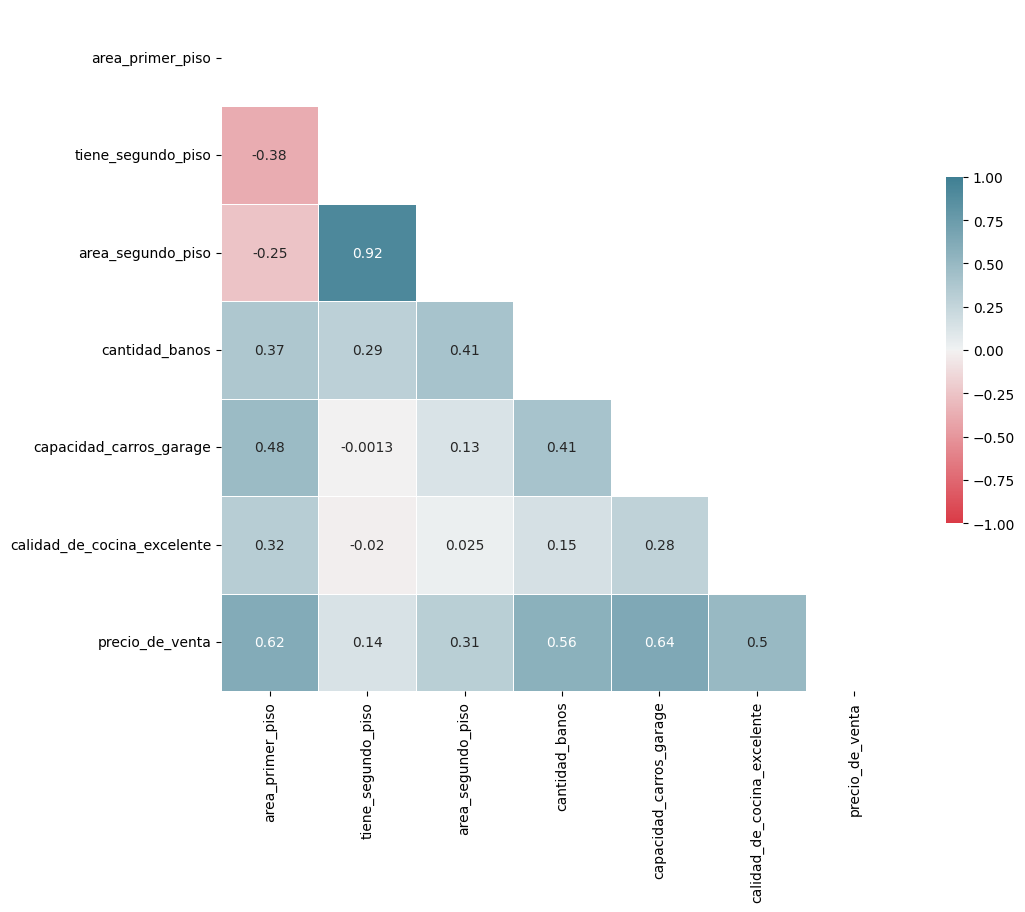

In [8]:
# Actividad
# Cuáles factores están más correlacionados?
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Generar el mapa de calor (heatmap)
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Mostrar el mapa de calor (heatmap)
plt.show()

## Relacionando variables

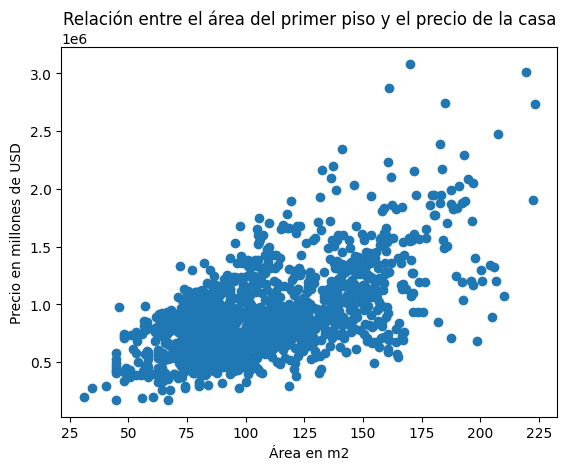

In [9]:
# Cómo se relacionan el área construída y el precio del inmueble?
plt.scatter(x='area_primer_piso', y='precio_de_venta', data= datos)
plt.title('Relación entre el área del primer piso y el precio de la casa')
plt.xlabel('Área en m2')
plt.ylabel('Precio en millones de USD')
plt.show()

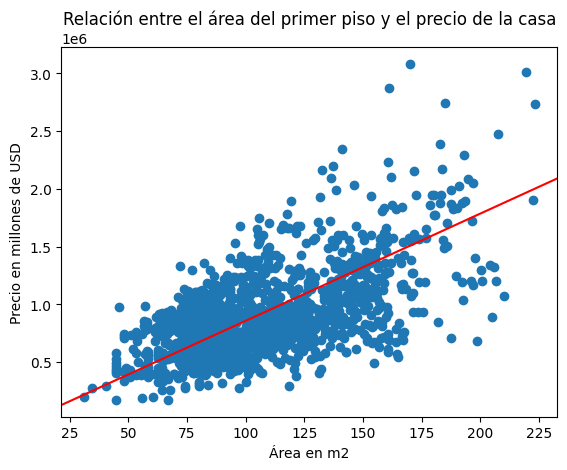

In [10]:
# Aparentemente mientras mayor es el área del primer piso, mayor es el precio de la casa.
# ¿Y si quisieramos trazar una línea que nos permita describir este comportamiento?
plt.scatter(x='area_primer_piso', y='precio_de_venta', data= datos)
plt.axline(xy1=(40,300000), xy2=(180,1600000), color='red')
plt.title('Relación entre el área del primer piso y el precio de la casa')
plt.xlabel('Área en m2')
plt.ylabel('Precio en millones de USD')
plt.show()

## Mejor recta

In [11]:
# Cuál es la recta que mejor se ajusta a esta relación
fig = px.scatter(datos, x='area_primer_piso', y='precio_de_venta', trendline="ols", trendline_color_override='red')
fig.show()


# 2. Explicando la recta
Ajustamos una recta entre los $m^2$ del primer piso y el precio de la casa. Queremos explicar el precio de la casa a partir de su tamaño, por eso decimos que:

* Variable explicativa/independiente: Área del primer piso  
* Variable de respuesta/dependiente: Precio de la casa  

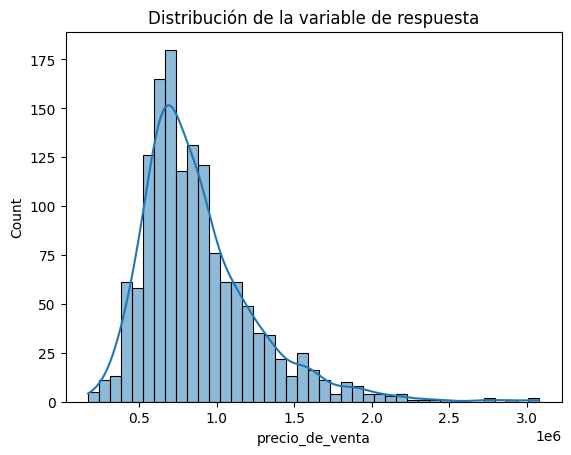

In [12]:
#Quién es nuestra variable de respuesta?
sns.histplot(data= datos, x='precio_de_venta', kde=True)
plt.title('Distribución de la variable de respuesta')
plt.show()

### Separando datos para entrenamiento y para prueba

El conjunto de **entrenamiento** se utiliza para ajustar el modelo, mientras que el conjunto de **prueba** se usa para evaluar su desempeño al predecir precios de viviendas no vistos durante el entrenamiento, lo que ayuda a la generalización del modelo.

In [13]:
#Datos de entrenamiento para usar la fórmula
variable_dependiente = datos['precio_de_venta']
variables_independientes = datos.drop(columns='precio_de_venta')

#Se usó el 30% de los datos para el conjunto de prueba
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(variables_independientes,
                                                                       variable_dependiente,
                                                                       test_size=0.3,
                                                                       random_state=230)

In [14]:
#Tipo de objetos producidos por train_test_split: Los mismos que los parámetros X y Y ingresados.
type(x_entrenamiento)

pandas.core.frame.DataFrame

In [15]:
#Generando el dataframe de entrenamiento.
datos_entrenamiento = pd.DataFrame(x_entrenamiento)
datos_entrenamiento.loc[:,'precio_de_venta'] = y_entrenamiento
datos_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006 entries, 1303 to 768
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   area_primer_piso             1006 non-null   float64
 1   tiene_segundo_piso           1006 non-null   int64  
 2   area_segundo_piso            1006 non-null   float64
 3   cantidad_banos               1006 non-null   int64  
 4   capacidad_carros_garage      1006 non-null   int64  
 5   calidad_de_cocina_excelente  1006 non-null   int64  
 6   precio_de_venta              1006 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 62.9 KB


In [16]:
# ajustando el primer modelo
modelo_ols = ols(formula='precio_de_venta  ~ area_primer_piso', data=datos_entrenamiento).fit()

In [17]:
type(modelo_ols)

statsmodels.regression.linear_model.RegressionResultsWrapper

## Analizando los coeficientes

(intensidad, dirección y significancia)




In [18]:
# visualizando los parámetros
modelo_ols.params

,0
Intercept,152909.288334
area_primer_piso,6793.641641


In [19]:
# El resumen del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:        precio_de_venta   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     608.3
Date:                Wed, 06 Aug 2025   Prob (F-statistic):          2.22e-105
Time:                        04:47:18   Log-Likelihood:                -14082.
No. Observations:                1006   AIC:                         2.817e+04
Df Residuals:                    1004   BIC:                         2.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.529e+05   3.07e+04  

- El **punto de intercepción** es el valor esperado del precio de la casa cuando todas las demás variables son cero. En este caso, cuando todas las demás variables, incluida el área del primer piso, son cero, el precio esperado de la casa es de $145.196,40. No siempre se tiene una interpretación práctica para este número.

- El **efecto individual** del área es de \$6.833,97. Esto indica que por cada metro cuadrado adicional al área del primer piso, se espera que el precio de la casa aumente en promedio \$6.833,97.

<img src="https://i.ibb.co/CJwfMgW/coeficientes.png" alt="coeficientes" border="0">


## Explicabilidad del modelo

**¿En qué medida la variación del área explica los diversos precios de las casas?**  

En este caso, recurrimos a la métrica R², el coeficiente de determinación. El R² varía de 0 a 1, donde 1 indica un ajuste perfecto del modelo a los datos, es decir, todas las variaciones en la variable dependiente son explicadas por las variables independientes en el modelo. Por otro lado, un R² de 0 indica que el modelo no explica ninguna variabilidad en la variable dependiente.

In [20]:
# observando el R²
round(modelo_ols.rsquared,2)

np.float64(0.38)

## Entendiendo el resíduo

In [21]:
# Quiénes son los residuos?
modelo_ols.resid.head()

,0
1303,-193023.838744
326,-144522.356193
386,399612.747641
615,-68449.596607
236,166010.592859


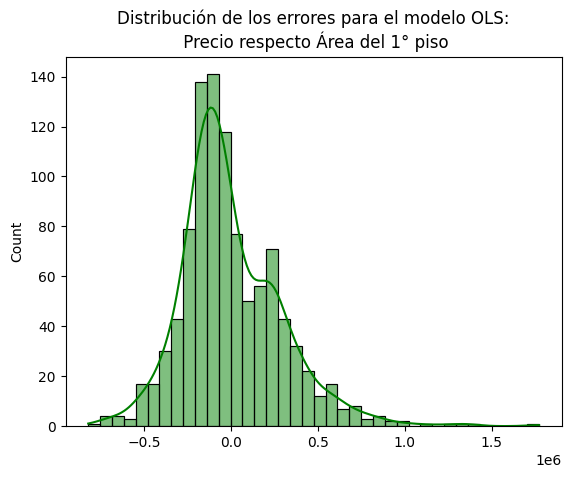

In [22]:
# Cómo están distribuidos
'''
Idealmente, deberían concentrarse alrededor de cero. Esto aseguraría
predicciones más precisas en conjuntos de datos nuevos (como los de prueba).
'''
sns.histplot(data=modelo_ols.resid, kde=True, color='green')
plt.title('Distribución de los errores para el modelo OLS:\n Precio respecto Área del 1° piso')
plt.show()

<img src="https://i.ibb.co/zGTB35V/residuos.png" alt="residuos" border="0">

## Obteniendo el R² de la previsión

In [23]:
# definiendo la 'Y' prevista
y_pred = modelo_ols.predict(x_prueba)

In [24]:
# mostrando el resultado de r²
print(f'El coeficiente de determinación R² para el modelo en el conjunto de prueba es {round(r2_score(y_true=y_prueba,y_pred=y_pred),2)}')

El coeficiente de determinación R² para el modelo en el conjunto de prueba es 0.39


# 3. Añadiendo otras características

El modelo con un solo factor nos mostró un R² de 0.38, es decir, aproximadamente el 38% de la variación observada en los precios de las casas puede explicarse por la variación en el área.  
Esto indica que aún existe una cantidad significativa de variación que no está siendo capturada por este modelo específico. Analizaremos otros factores para explicar el precio de las casas.

## Analizando los factores

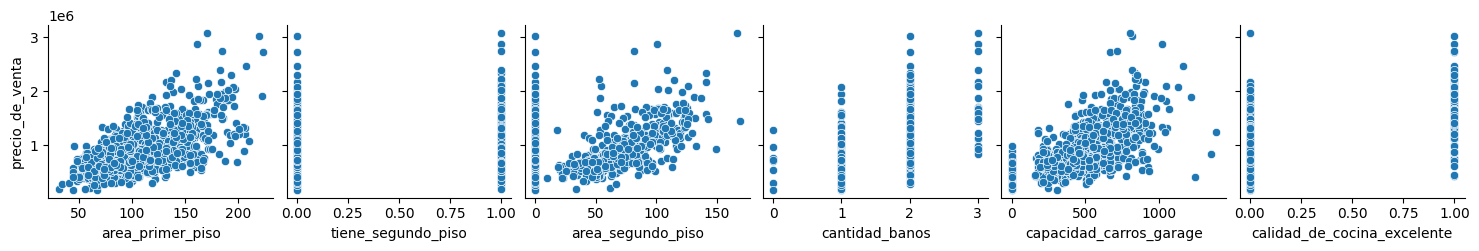

In [25]:
# cuáles otras características podrían explicar el precio de los inmuebles?
sns.pairplot(data=datos, x_vars=['area_primer_piso', 'tiene_segundo_piso',
                                 'area_segundo_piso', 'cantidad_banos',
                                 'capacidad_carros_garage', 'calidad_de_cocina_excelente'],
             y_vars='precio_de_venta')

## Añadiendo factores al modelo con **`statsmodels.api`**
A diferencia de `statsmodels.formula.api`, en lugar de usar el df datos_entrenamiento, se crearán los modelos de regresión lineal usando los dataframes: **x_entrenamiento** y **y_entrenamiento**.

In [26]:
# Añadiendo una constante
x_entrenamiento = sm.add_constant(x_entrenamiento)
type(x_entrenamiento)

pandas.core.frame.DataFrame

In [27]:
x_entrenamiento.columns

Index(['const', 'area_primer_piso', 'tiene_segundo_piso', 'area_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente'],
      dtype='object')

In [28]:
# Creando el modelo de regresión (con todas las variables): saturado
modelo_1 = sm.OLS(endog=y_entrenamiento, exog=x_entrenamiento[['const',
                                                            'area_primer_piso',
                                                            'tiene_segundo_piso',
                                                            'area_segundo_piso',
                                                            'cantidad_banos',
                                                            'capacidad_carros_garage',
                                                            'calidad_de_cocina_excelente']]).fit()

In [29]:
# Modelo sin el área del segundo piso
modelo_2 = sm.OLS(endog=y_entrenamiento, exog=x_entrenamiento[['const',
                                                            'area_primer_piso',
                                                            'tiene_segundo_piso',
                                                            'cantidad_banos',
                                                            'capacidad_carros_garage',
                                                            'calidad_de_cocina_excelente']]).fit()

In [30]:
# Modelo sin la información del garage
# Modelo sin el área del segundo piso
modelo_3 = sm.OLS(endog=y_entrenamiento, exog=x_entrenamiento[['const',
                                                            'area_primer_piso',
                                                            'tiene_segundo_piso',
                                                            'cantidad_banos',
                                                            'calidad_de_cocina_excelente']]).fit()

In [31]:
# Resumen del modelos
modelos = [modelo_ols, modelo_1, modelo_2, modelo_3]

for i,j in enumerate(modelos):
  print("*" * 78)
  print("*" * 34 + f' Modelo {i} ' + "*" * 34)
  print("*" * 78)
  print(j.summary(),'\n\n')

******************************************************************************
********************************** Modelo 0 **********************************
******************************************************************************
                            OLS Regression Results                            
Dep. Variable:        precio_de_venta   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     608.3
Date:                Wed, 06 Aug 2025   Prob (F-statistic):          2.22e-105
Time:                        04:47:20   Log-Likelihood:                -14082.
No. Observations:                1006   AIC:                         2.817e+04
Df Residuals:                    1004   BIC:                         2.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust               

In [32]:
#Coeficiente de determinación por modelo.
for i,j in enumerate(modelos):
  print(f'El coeficiente de determinación R² para el modelo {i} es: {round(j.rsquared,2)}')

El coeficiente de determinación R² para el modelo 0 es: 0.38
El coeficiente de determinación R² para el modelo 1 es: 0.74
El coeficiente de determinación R² para el modelo 2 es: 0.71
El coeficiente de determinación R² para el modelo 3 es: 0.65


## Comparando los modelos
¿Cuál es el modelo escogido? El modelo 3, debido a la ausencia de mensajes que adviertan multicolinealidad y tener el R² ajustado alto.


In [33]:
# Cuántos parámetros tiene el modelo?
modelo_3.params

,0
const,-129979.678094
area_primer_piso,6119.653184
tiene_segundo_piso,221306.959705
cantidad_banos,149036.289458
calidad_de_cocina_excelente,444391.228573


## Desafío del aula 3
A partir del siguiente [dataset](https://cdn3.gnarususercontent.com.br/3677-data-science-regressao-linear/Projeto/Base%20de%20dados/hoteis.csv), se realizaron las siguientes etapas:

1. Análisis inicial con el PairPlot de Seaborn;
2. Construir modelos de regresión lineal; y
3. Realizar la comparación de estos modelos.

In [35]:
#Identificación del encode.
import chardet
with open('/content/desafio-3-precios-hoteles.csv','rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']
print(encode)

ascii


In [36]:
#Importación del modelo.
url_desafio_3 = 'https://github.com/JLuceroVasquez/data-science-probando-relaciones-con-regresion-lineal/raw/refs/heads/main/datos-desafios/desafio-3-precios-hoteles.csv'

datos_desafio_3 = pd.read_csv(url_desafio_3, encoding='ascii')
datos_desafio_3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estrelas            1000 non-null   int64  
 1   ProximidadeTurismo  1000 non-null   float64
 2   Capacidade          1000 non-null   int64  
 3   Preco               1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


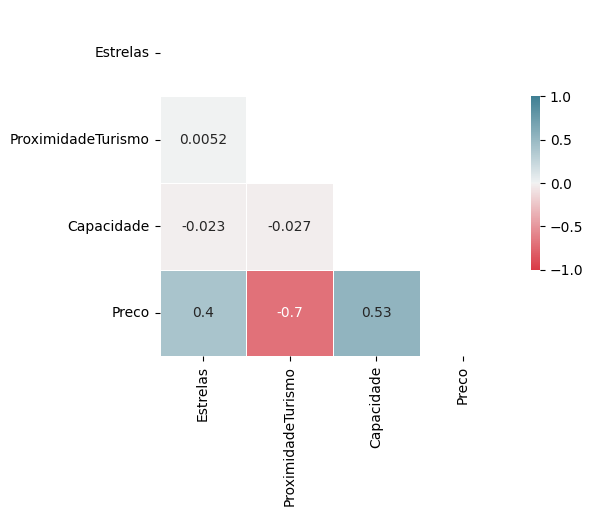

In [37]:
#Análisis de coeficientes de correlación entre variables.
corr_desafio_3 = datos_desafio_3.corr()

# Generar una máscara para ocultar el triángulo superior
mascara_desafio_3 = np.zeros_like(corr_desafio_3, dtype=bool)
mascara_desafio_3[np.triu_indices_from(mascara_desafio_3)] = True

# Configurar la figura de matplotlib
fig, ax = plt.subplots(figsize=(6.5, 4.5))

# Generar el mapa de calor (heatmap)
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_desafio_3, mask=mascara_desafio_3, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Mostrar el mapa de calor (heatmap)
plt.show()

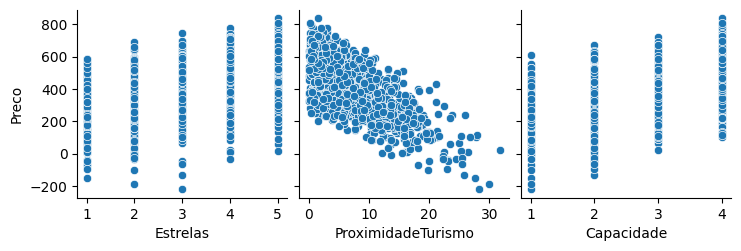

In [38]:
#Visualización inicial de variables con PairPlot.
sns.pairplot(data=datos_desafio_3, x_vars=['Estrelas', 'ProximidadeTurismo', 'Capacidade'],
             y_vars='Preco')

In [39]:
#División del dataset en datos de entrenamiento y prueba (30%).
variable_dependiente_desafio_3 = datos_desafio_3['Preco']
variables_independientes_desafio_3 = datos_desafio_3.drop(columns='Preco')

x_train_desafio_3, x_test_desafio_3, y_train_desafio_3, y_test_desafio_3 = train_test_split(variables_independientes_desafio_3,
                                                                                            variable_dependiente_desafio_3,
                                                                                            test_size=0.3,
                                                                                            random_state=101)

In [40]:
#Se añade una constante a las variables predictivas.
x_train_desafio_3 = sm.add_constant(x_train_desafio_3)
x_train_desafio_3.columns

Index(['const', 'Estrelas', 'ProximidadeTurismo', 'Capacidade'], dtype='object')

In [41]:
#Construcción y entrenamiento de los modelos de regresión lineal.

#Modelo 0. Saturado.
modelo_0_desafio_3 = sm.OLS(endog=y_train_desafio_3, exog=x_train_desafio_3).fit()

#Modelo 1. Solo: ProximidadeTurismo y Capacidade.
modelo_1_desafio_3 = sm.OLS(endog=y_train_desafio_3, exog=x_train_desafio_3[['const',
                                                                             'ProximidadeTurismo',
                                                                             'Capacidade']]).fit()

#Modelo 2. Solo: ProximidadeTurismo.
modelo_2_desafio_3 = sm.OLS(endog=y_train_desafio_3, exog=x_train_desafio_3[['const',
                                                                             'ProximidadeTurismo']]).fit()

In [42]:
#Comparación del resumen de los modelos.
modelos_desafio_3 = [modelo_0_desafio_3, modelo_1_desafio_3, modelo_2_desafio_3]

for i,j in enumerate(modelos_desafio_3):
  print("*" * 78)
  print("*" * 34 + f' Modelo {i} ' + "*" * 34)
  print("*" * 78)
  print(j.summary(),'\n\n')

******************************************************************************
********************************** Modelo 0 **********************************
******************************************************************************
                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     2757.
Date:                Wed, 06 Aug 2025   Prob (F-statistic):               0.00
Time:                        04:48:09   Log-Likelihood:                -3693.1
No. Observations:                 700   AIC:                             7394.
Df Residuals:                     696   BIC:                             7412.
Df Model:                           3                                         
Covariance Type:            nonrobust               

In [43]:
#Comparación del R2 de los modelos.
for i,j in enumerate(modelos_desafio_3):
  print(f'El coeficiente de determinación R² ajustado para el modelo {i} es: {round(j.rsquared_adj,2)}')

El coeficiente de determinación R² ajustado para el modelo 0 es: 0.92
El coeficiente de determinación R² ajustado para el modelo 1 es: 0.74
El coeficiente de determinación R² ajustado para el modelo 2 es: 0.49


El modelo saturado (modelo 0) para la actividad del desafío 3 es el más adecuado. Pues posee un número condicional menor a 100 (38.3) no advirtiendo colinealidad, y tiene el R² ajustado es el más alto entre los 3 modelos.

# 4. Precificando las casas

## Obteniendo el R² de la previsión

In [44]:
# Añadiendo una constante en X_test
x_prueba = sm.add_constant(x_prueba)
x_prueba.head(2)

,const,area_primer_piso,tiene_segundo_piso,area_segundo_piso,cantidad_banos,capacidad_carros_garage,calidad_de_cocina_excelente
997,1.0,94.9438,0,0.0000,1,280,0
805,1.0,74.1342,1,78.2218,2,595,0


In [45]:
# Previsión con el modelo 3
y_pred_3 = modelo_3.predict(x_prueba[['const',
                                      'area_primer_piso',
                                      'tiene_segundo_piso',
                                      'cantidad_banos',
                                      'calidad_de_cocina_excelente']])

In [46]:
# Cuál es el R² del entrenamiento?
print(f'El R² del modelo 3 con los datos de entrenamiento fue:{modelo_3.rsquared.round(2)}')

El R² del modelo 3 con los datos de entrenamiento fue:0.65


In [47]:
# Cuál es el r² de la previsión?
print(f'El R² del modelo 3 con los datos de prueba fue:{round(r2_score(y_prueba, y_pred_3), 2)}')

El R² del modelo 3 con los datos de prueba fue:0.64


## Precificando una casa

<img src="https://i.ibb.co/SvG4V4j/costo.png" alt="costo" border="0">

In [48]:
#Nuevo inmueble
nuevo_inmueble = pd.DataFrame(data={
    'const':[1],
    'area_primer_piso': [120],
    'tiene_segundo_piso': [1],
    'cantidad_banos': [2],
    'calidad_de_cocina_excelente': [0],
})

In [49]:
# Cuál es el precio del inmueble de acuerdo con el modelo 0?
precio_nuevo_inmueble_0 = modelo_ols.predict(nuevo_inmueble[['const','area_primer_piso']])
print(f'Según el modelo predictivo 0, el precio del inmueble es ${precio_nuevo_inmueble_0.values[0]:,.2f}')

Según el modelo predictivo 0, el precio del inmueble es $968,146.29


In [50]:
#Cuál es el precio del inmueble de acuerdo con el modelo 3?
precio_nuevo_inmueble_3 = modelo_3.predict(nuevo_inmueble)
print(f'Según el modelo predictivo 3, el precio del inmueble es ${precio_nuevo_inmueble_3.values[0]:,.2f}')

Según el modelo predictivo 3, el precio del inmueble es $1,123,758.24


In [51]:
modelo_3.params

,0
const,-129979.678094
area_primer_piso,6119.653184
tiene_segundo_piso,221306.959705
cantidad_banos,149036.289458
calidad_de_cocina_excelente,444391.228573


## Precificando varias casas
Se predijo el precio para 10 casas nuevas, según los datos del archivo descargado [aquí](https://github.com/alura-es-cursos/2145-data-science-probando-relaciones-con-regresion-lineal/blob/aula-4/nuevas_casas.csv).

<img src="https://i.imgur.com/i0skFlB.jpeg" width="600"/>

In [52]:
# Verificando el encode
import chardet
with open('/content/aula-4-precios-nuevas-casas.csv','rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']

print(encode)

UTF-8-SIG


In [53]:
# Importando el dataframes
url_aula_4 = 'https://github.com/JLuceroVasquez/data-science-probando-relaciones-con-regresion-lineal/raw/refs/heads/main/datos-desafios/aula-4-precios-nuevas-casas.csv'

nuevas_casas = pd.read_csv(url_aula_4, sep=';', encoding='UTF-8-SIG')
nuevas_casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Casa                         10 non-null     int64
 1   area_primer_piso             10 non-null     int64
 2   tiene_segundo_piso           10 non-null     int64
 3   cantidad_banos               10 non-null     int64
 4   calidad_de_cocina_excelente  10 non-null     int64
dtypes: int64(5)
memory usage: 532.0 bytes


In [54]:
# Añadiendo una constante
nuevas_casas.drop(columns='Casa', inplace=True)
nuevas_casas = sm.add_constant(nuevas_casas)
nuevas_casas.head(2)

,const,area_primer_piso,tiene_segundo_piso,cantidad_banos,calidad_de_cocina_excelente
0,1.0,150,1,2,1
1,1.0,180,0,3,1


In [55]:
# Cuál es el precio de estas nuevas casas?
nuevas_casas['precio_de_venta'] = modelo_3.predict(nuevas_casas[['const',
                                                                 'area_primer_piso',
                                                                 'tiene_segundo_piso',
                                                                 'cantidad_banos',
                                                                 'calidad_de_cocina_excelente']]).round(2)
nuevas_casas.head()

,const,area_primer_piso,tiene_segundo_piso,cantidad_banos,calidad_de_cocina_excelente,precio_de_venta
0,1.0,150,1,2,1,1751739.07
1,1.0,180,0,3,1,1863057.99
2,1.0,120,1,2,1,1568149.47
3,1.0,200,1,3,1,2206758.02
4,1.0,160,0,2,1,1591628.64


## Desafío del aula 4
Se predijo el precio para la siguiente casa:

<img src="https://cdn3.gnarususercontent.com.br/2145-data-science-probando-relaciones-con-regresion-lineal/Imagenes/7.HagaLoQueHicimos.png" width="600"/>

In [56]:
#Se crea el dataframe con los datos del inmueble.
nuevo_inmueble_desafio_4 = pd.DataFrame({'const':[1],
                               'area_primer_piso':[98],
                               'existe_segundo_piso': [0],
                               'cantidad_baños': [1],
                               'calidad_de_la_cocina_Excelente': [1]
                               })

In [57]:
#Se predice el precio usando el modelo 3.
precio_nuevo_inmueble_desafio_4 = modelo_3.predict(nuevo_inmueble_desafio_4)
print(f'Según el modelo predictivo 3, el precio del inmueble es ${precio_nuevo_inmueble_desafio_4.values[0]:,.2f}')

Según el modelo predictivo 3, el precio del inmueble es $1,063,173.85


## Exportamos el modelo 3 en un archivo
Después de entrenar el modelo, podemos guardarlo en un archivo usando la biblioteca pickle. Para ello, es necesario importar la biblioteca y luego podemos usar la función `pickle.dump()`, indicando el modelo y el archivo como parámetros.

In [58]:
import pickle

# Nombre del archivo donde se guardará el modelo
nombre_archivo = 'modelo_regresion_lineal.pkl'

# Guardar el modelo en un archivo usando pickle
with open(nombre_archivo, 'wb') as archivo:
    pickle.dump(modelo_3, archivo)

# 5. Investigando el modelo





## Multicolinearidad

Cuando dos o más cosas que estás intentando estudiar son tan parecidas que es difícil determinar cuánto está influyendo cada una de ellas en el resultado.

In [65]:
# Se crean lista con las variables explicativas de los modelos
explicativas_modelo_1 = ['const','area_primer_piso', 'tiene_segundo_piso',
                         'area_segundo_piso', 'cantidad_banos',
                         'capacidad_carros_garage', 'calidad_de_cocina_excelente']

explicativas_modelo_2 = ['const','area_primer_piso', 'tiene_segundo_piso',
                         'cantidad_banos', 'capacidad_carros_garage',
                         'calidad_de_cocina_excelente']

explicativas_modelo_3 = ['const','area_primer_piso', 'tiene_segundo_piso',
                         'cantidad_banos', 'calidad_de_cocina_excelente']

In [67]:
# VIF 1
vif_1 = pd.DataFrame()
vif_1['Variable'] = explicativas_modelo_1
vif_1['VIF'] = [vif(exog=x_entrenamiento[explicativas_modelo_1], exog_idx=i) for i in range(len(explicativas_modelo_1))]
vif_1.round(2)

,Variable,VIF
0,const,20.23
1,area_primer_piso,2.19
2,tiene_segundo_piso,7.46
3,area_segundo_piso,7.59
4,cantidad_banos,1.72
5,capacidad_carros_garage,1.57
6,calidad_de_cocina_excelente,1.18


In [69]:
# VIF 2
vif_2 = pd.DataFrame()
vif_2['Variable'] = explicativas_modelo_2
vif_2['VIF'] = [vif(exog=x_entrenamiento[explicativas_modelo_2], exog_idx=i) for i in range(len(explicativas_modelo_2))]
vif_2.round(2)

,Variable,VIF
0,const,18.79
1,area_primer_piso,2.19
2,tiene_segundo_piso,1.67
3,cantidad_banos,1.61
4,capacidad_carros_garage,1.51
5,calidad_de_cocina_excelente,1.18


In [68]:
# VIF 3
vif_3 = pd.DataFrame()
vif_3['Variable'] = explicativas_modelo_3
vif_3['VIF'] = [vif(exog=x_entrenamiento[explicativas_modelo_3], exog_idx=i) for i in range(len(explicativas_modelo_3))]
vif_3.round(2)

,Variable,VIF
0,const,18.77
1,area_primer_piso,1.92
2,tiene_segundo_piso,1.64
3,cantidad_banos,1.54
4,calidad_de_cocina_excelente,1.15


## Análisis de los residuos

Residuos: la discrepancia entre los valores reales y los valores que el modelo predice para los mismos puntos de datos.

In [71]:
#Se crea un dataframe con los valores previstos para los datos de entrenamiento
y_pred_3_entrenamiento = modelo_3.predict(x_entrenamiento[explicativas_modelo_3])

In [75]:
#Se genera un gráfico de dispersión con los valores previstos y reales
fig = px.scatter(x=y_pred_3_entrenamiento, y =y_entrenamiento,
           title='Dispersión: Valores previsto vs Reales',
           labels={'x':'Valores previstos', 'y':'Valores reales'})
fig.show()

In [76]:
#Se genera un gráfico de dispersión con los valores previstos y residuos
residuos_modelo_3 = modelo_3.resid

fig = px.scatter(x=y_pred_3_entrenamiento, y =residuos_modelo_3,
           title='Dispersión: Valores previstos vs Residuos',
           labels={'x':'Valores previstos', 'y':'Residuos'})
fig.show()

<img src="https://i.ibb.co/9bmySbm/heterocedasticidad.png" alt="heterocedasticidad" border="0">

## Desafío del aula 5
En esta actividad, se aplicó los conceptos de multicolinealidad y homocedasticidad en un contexto diferente: el sector de energía. La base de datos se puede descargar haciendo [click aquí](https://cdn3.gnarususercontent.com.br/3677-data-science-regressao-linear/Projeto/Base%20de%20dados/usina.csv).

Este proyecto se llevó a cabo en dos etapas:
* **Primera etapa:** Se construyó un modelo de regresión lineal asumiendo que la columna PE es la variable y.

* **Segunda etapa:** Se verificó la multicolinealidad utilizando el concepto de VIF. En caso de indicios de multicolinealidad entre las variables, se sugirieron las medidas que se pueden tomar.

* **Tercera etapa:** Se realizó un análisis de residuos e identificó si hay o no heterocedasticidad en los datos.

* **Cuarta etapa:** Se calculó el coeficiente de determinación del modelo para los datos de entrenamiento y prueba. Obteniendose medidas semejantes, que indica la no ocurrencia de overfitting.



### Etapa 1: Construcción y entrenamiento del modelo

In [77]:
#Se detectó el encoding
with open('/content/desafio-5-usina.csv','rb') as file:
  diccionario = chardet.detect(file.read())
  encode = diccionario['encoding']

print(encode)

ascii


In [78]:
#Se importó el dataframe
url_desafio_5 = 'https://github.com/JLuceroVasquez/data-science-probando-relaciones-con-regresion-lineal/raw/refs/heads/main/datos-desafios/desafio-5-usina.csv'
datos_desafio_5 = pd.read_csv(url_desafio_5, encoding='ascii')
datos_desafio_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [79]:
#Se separó los datos en entrenamiento y prueba (30%)
variable_dependiente_desafio_5 = datos_desafio_5['PE']
variables_independientes_desafio_5 = datos_desafio_5.drop(columns='PE')

x_train_desafio_5, x_test_desafio_5, y_train_desafio_5, y_test_desafio_5 = train_test_split(variables_independientes_desafio_5,
                                                                                            variable_dependiente_desafio_5,
                                                                                            test_size=0.3,
                                                                                            random_state=101)

In [81]:
#Se añadió una columna para la constante, así como se construyó y entrenó el modelo
x_train_desafio_5 = sm.add_constant(x_train_desafio_5)

modelo_desafio_5 = sm.OLS(endog=y_train_desafio_5, exog=x_train_desafio_5).fit()

print(modelo_desafio_5.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.216e+04
Date:                Wed, 06 Aug 2025   Prob (F-statistic):               0.00
Time:                        06:01:05   Log-Likelihood:                -19643.
No. Observations:                6697   AIC:                         3.930e+04
Df Residuals:                    6692   BIC:                         3.933e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.8885     11.619     39.150      0.0

### Etapa 2: Verificación de la multicolinealidad
Considerando un valor máximo aceptable de 5, se eliminó la variable AT como predictora. Cabe precisar que tras este cambio, el resumen del modelo siguió advirtiendo un valor de condición alto debido al alto valor del VIF para la constante.

In [82]:
#Se cálcula el factor de inflación de la varianza para cada predictora del modelo
vif_desafio_5 = pd.DataFrame()
vif_desafio_5['Variable'] = x_train_desafio_5.columns
vif_desafio_5['VIF'] = [vif(x_train_desafio_5, i)for i in range(len(x_train_desafio_5.columns))]
vif_desafio_5

,Variable,VIF
0,const,43727.632070
1,AT,5.958433
2,V,3.977583
3,AP,1.451825
4,RH,1.686514


In [86]:
#Se genera un nuevo modelo sin la variable AT
predictoras = ['const', 'V', 'AP', 'RH']

modelo_2_desafio_5 = sm.OLS(endog=y_train_desafio_5, exog=x_train_desafio_5[predictoras]).fit()

print(modelo_2_desafio_5.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     9192.
Date:                Wed, 06 Aug 2025   Prob (F-statistic):               0.00
Time:                        06:12:57   Log-Likelihood:                -23069.
No. Observations:                6697   AIC:                         4.615e+04
Df Residuals:                    6693   BIC:                         4.617e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -67.3233     17.662     -3.812      0.0

### Etapa 3: Verificación de heterocedasticidad
A simple vista el modelo presenta homocedasticidad.

In [89]:
#Se calcularon predicciones para datos de entrenamiento y los residuos del modelo
y_pred_train_desafio_5 = modelo_2_desafio_5.predict(x_train_desafio_5[predictoras])
residuos_modelo_2_desafio_5 = modelo_2_desafio_5.resid

#Se generó con ambos un gráfico de dispersión
fig = px.scatter(x=y_pred_train_desafio_5, y=residuos_modelo_2_desafio_5,
                 title='Varianza de los residuos de las predicciones',
                 labels={'x':'Predicciones', 'y':'Residuos'})
fig.show()

### Etapa 3: Verificación del coeficiente de determinación

In [91]:
#Se añadió la columna de constante las variables predictoras de los datos de prueba.
x_test_desafio_5 = sm.add_constant(x_test_desafio_5)

#Se usó el modelo para la predicción con los datos de prueba
y_test_pred_desafio_5 = modelo_2_desafio_5.predict(x_test_desafio_5[predictoras])

In [93]:
#Se comparó los R2 de los datos de entrenamiento y prueba

#R2 de los datos de entrenamiento
print(f'El coeficiente de determinación R² para el modelo en el conjunto de prueba es {round(modelo_2_desafio_5.rsquared,3)}')

#R2 de los datos de prueba
print(f'El coeficiente de determinación R² para el modelo en el conjunto de prueba es {round(r2_score(y_test_desafio_5,y_test_pred_desafio_5),3)}')

El coeficiente de determinación R² para el modelo en el conjunto de prueba es 0.805
El coeficiente de determinación R² para el modelo en el conjunto de prueba es 0.801
